In [1]:
import pyarrow.parquet as pq
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
# Задаем данные

target_file_path = "train_target.csv"
file_path = 'train_data/train_data_5.pq'

target_df = pd.read_csv(target_file_path)


table = pq.read_table(file_path)
df = table.to_pandas()
# Добавление столбца с таргетом
df = pd.merge(df, target_df[['id', 'flag']], on='id', how='left')

print(f"Обработка файла завершена.")

Обработка файла завершена.


id      0
flag    0
dtype: int64
________________________________


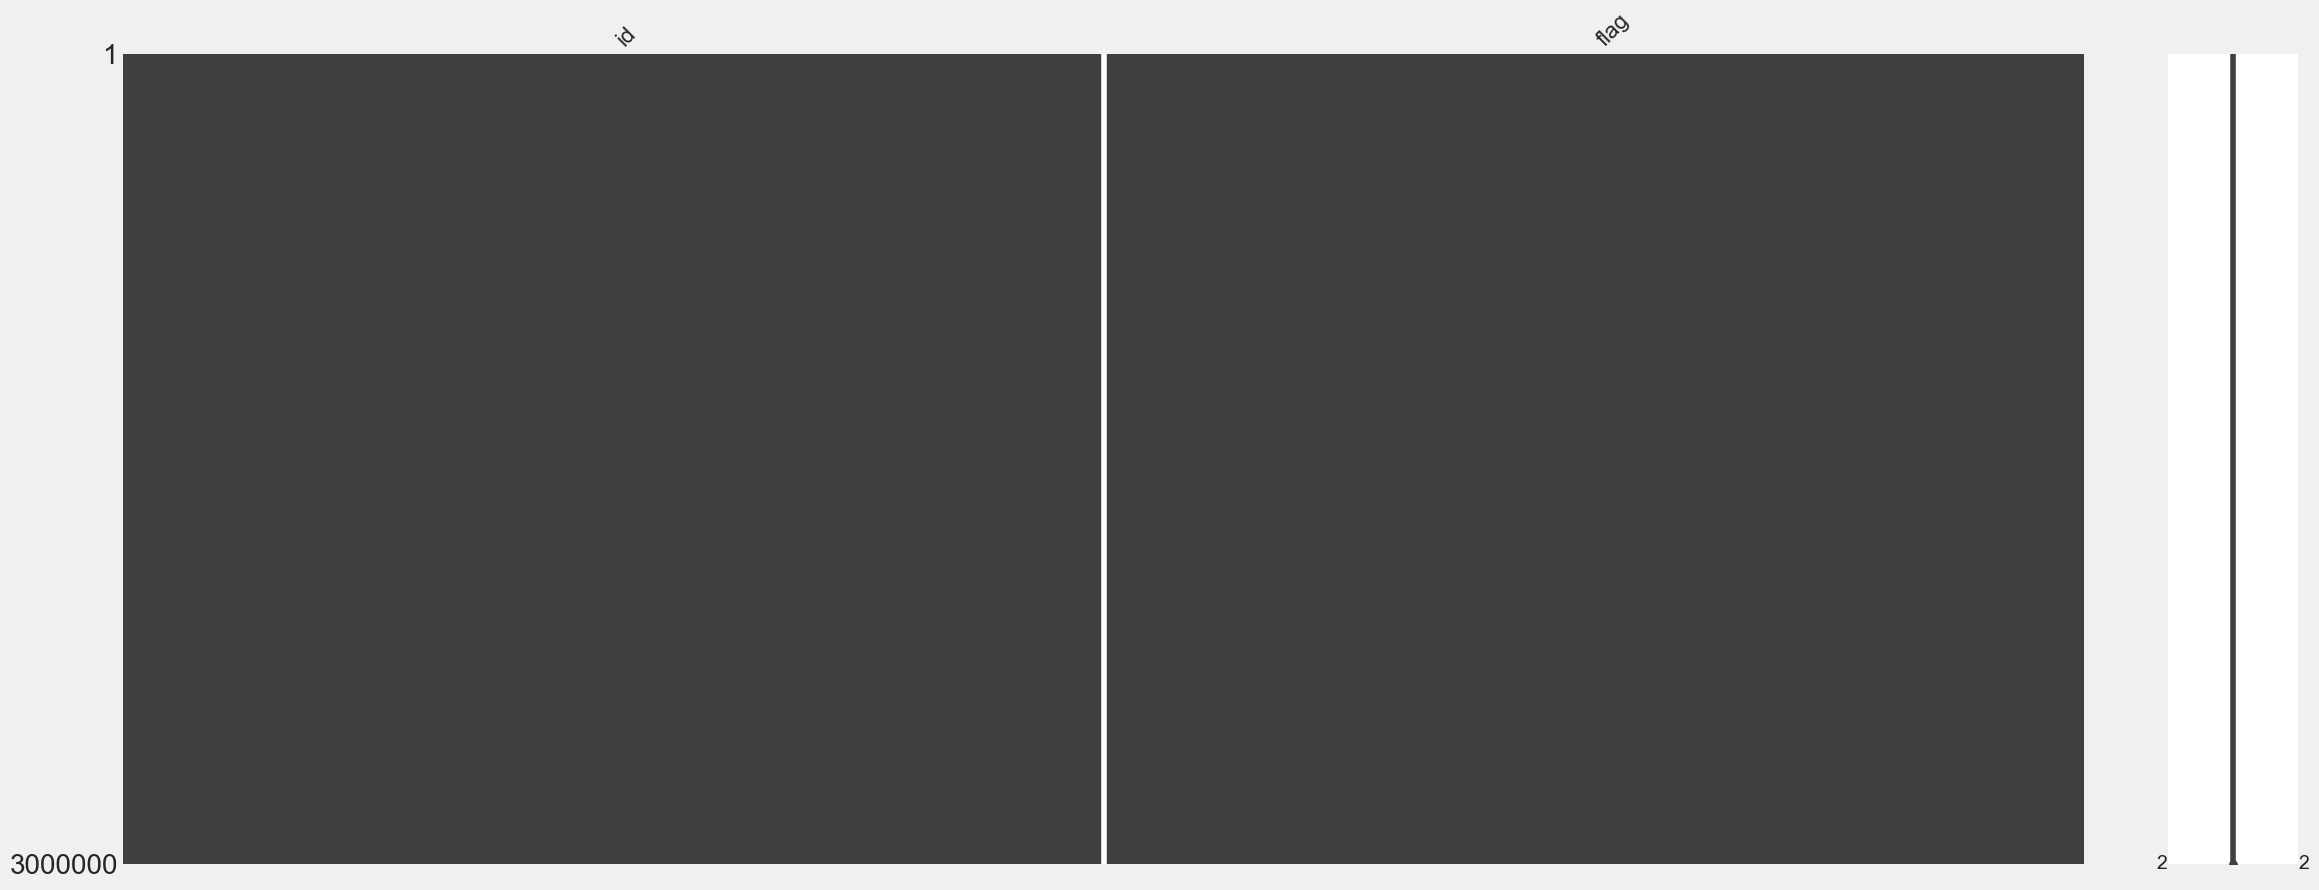

________________________________
Пропусков нет в данных.
________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   id      int64
 1   flag    int64
dtypes: int64(2)
memory usage: 45.8 MB
________________________________
                 id          flag
count  3.000000e+06  3.000000e+06
mean   1.500000e+06  3.548067e-02
std    8.660255e+05  1.849914e-01
min    0.000000e+00  0.000000e+00
25%    7.499998e+05  0.000000e+00
50%    1.500000e+06  0.000000e+00
75%    2.249999e+06  0.000000e+00
max    2.999999e+06  1.000000e+00
________________________________
flag
0    2893558
1     106442
Name: count, dtype: int64
________________________________


In [3]:
# Смотрим пропуски

print(target_df.isna().sum())
print('________________________________')

# Смотрим пропуски на графике
msno.matrix(target_df)
plt.show()
print('________________________________')
# Пробуем найти даже 1 пропуск, который не видно на графике и можно было бы не заметить при просмотре вывода строки 3-4. 

missing_columns = target_df.columns[target_df.isnull().any()]

if missing_columns.empty:
    print("Пропусков нет в данных.")
else:
    print("Пропуски обнаружены в следующих столбцах:")
    for column in missing_columns:
        missing_count = target_df[column].isnull().sum()
        print(f"{column}: {missing_count} пропусков")
print('________________________________')

# Информация о датафрейме
target_df.info()
print('________________________________')
# Описание датафрейма
print(target_df.describe())
print('________________________________')
# Баланс классов целевой переменной
print(target_df['flag'].value_counts())
print('________________________________')


In [4]:
df

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,1250000,1,17,3,15,12,11,0,16,2,...,3,3,4,1,3,4,1,0,0,0
1,1250000,2,9,10,14,7,10,4,15,5,...,3,3,4,1,2,4,1,0,0,0
2,1250001,1,16,5,8,6,4,9,18,2,...,3,3,4,1,2,4,1,0,0,1
3,1250001,2,18,5,16,16,5,6,6,2,...,0,3,4,1,3,4,1,0,0,1
4,1250001,3,5,12,16,8,11,11,3,6,...,3,3,4,1,3,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150903,1499999,4,4,17,8,11,5,7,13,2,...,3,3,4,1,3,5,1,0,0,0
2150904,1499999,5,5,8,4,3,5,7,13,2,...,3,3,4,1,3,5,1,0,0,0
2150905,1499999,6,2,0,14,8,14,11,2,2,...,3,3,4,1,2,4,1,0,1,0
2150906,1499999,7,2,6,14,7,14,8,2,5,...,3,3,4,1,2,4,1,0,0,0


id                       0
rn                       0
pre_since_opened         0
pre_since_confirmed      0
pre_pterm                0
                        ..
enc_loans_credit_type    0
enc_loans_account_cur    0
pclose_flag              0
fclose_flag              0
flag                     0
Length: 62, dtype: int64
________________________________


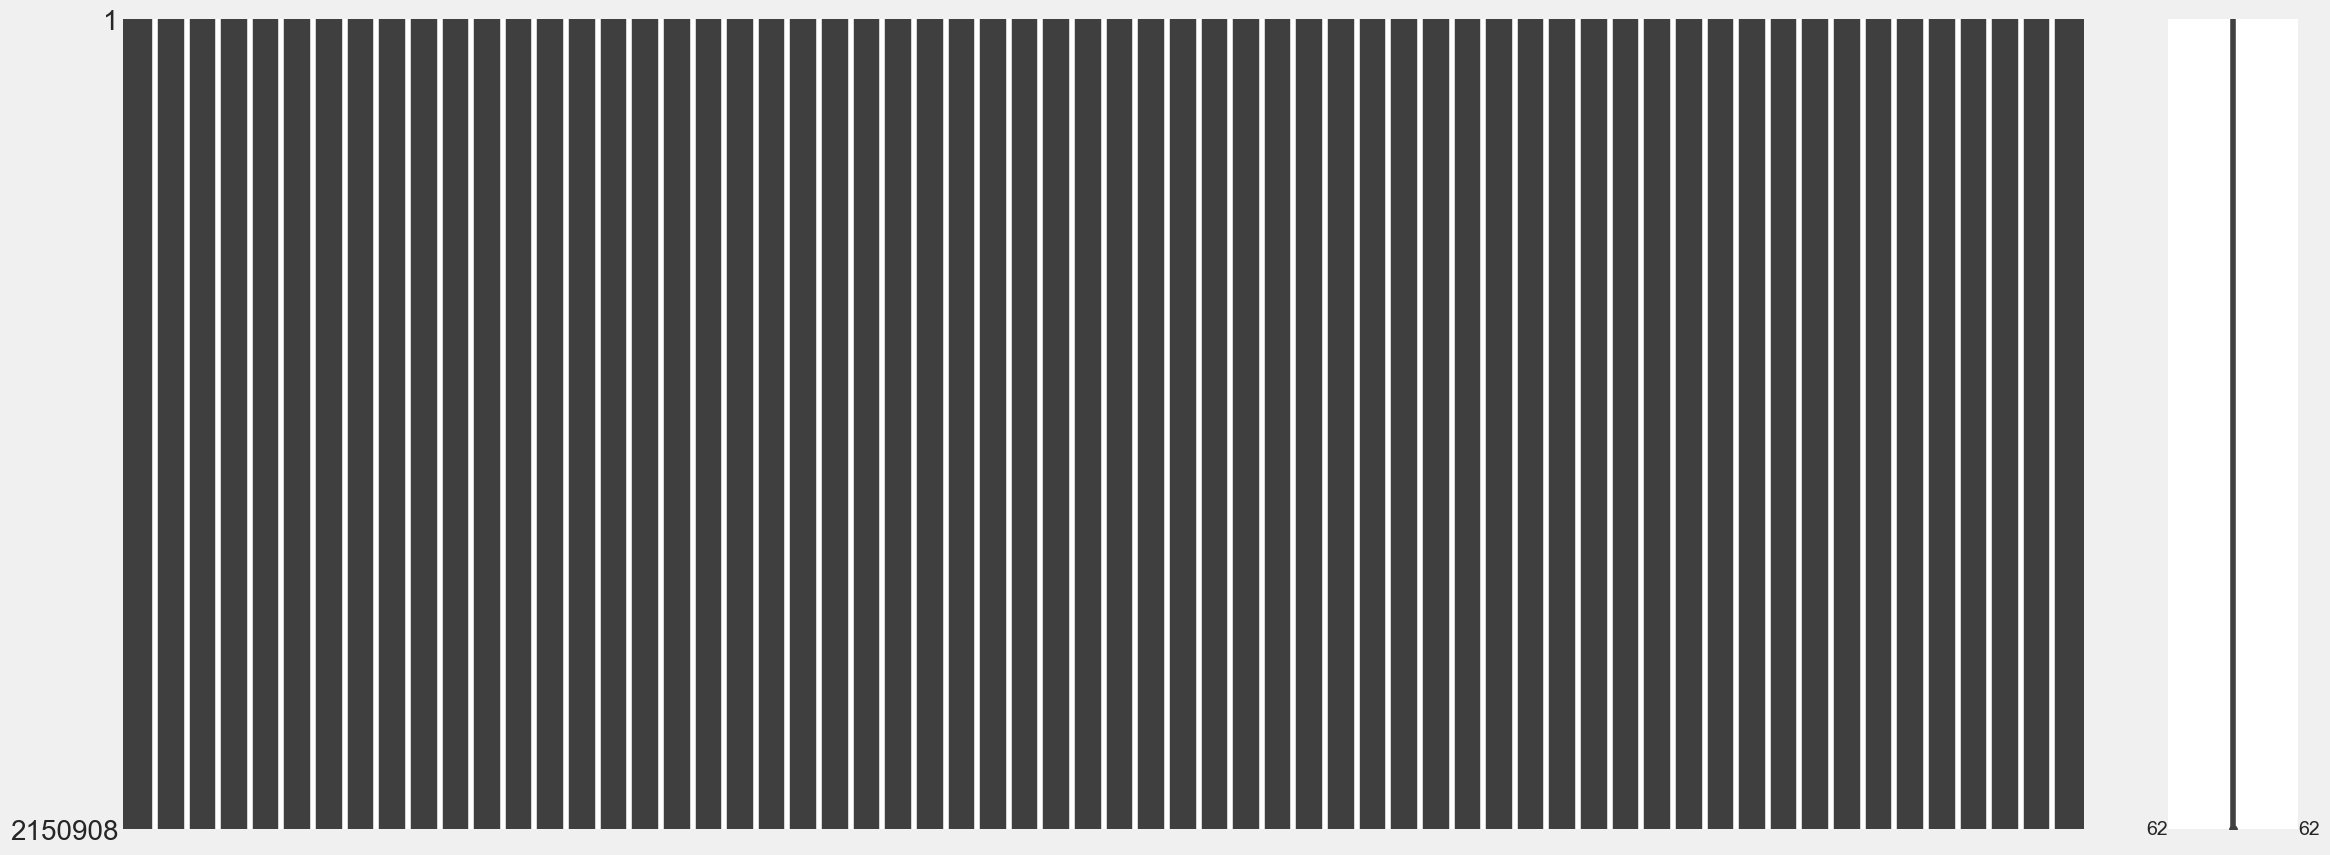

________________________________
Пропусков нет в данных.
________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2150908 entries, 0 to 2150907
Data columns (total 62 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int64
 2   pre_since_opened               int64
 3   pre_since_confirmed            int64
 4   pre_pterm                      int64
 5   pre_fterm                      int64
 6   pre_till_pclose                int64
 7   pre_till_fclose                int64
 8   pre_loans_credit_limit         int64
 9   pre_loans_next_pay_summ        int64
 10  pre_loans_outstanding          int64
 11  pre_loans_total_overdue        int64
 12  pre_loans_max_overdue_sum      int64
 13  pre_loans_credit_cost_rate     int64
 14  pre_loans5                     int64
 15  pre_loans530                   int64
 16  pre_loans3060                  int64

In [5]:
# Смотрим пропуски

print(df.isna().sum())
print('________________________________')
# Смотрим пропуски на графике
msno.matrix(df)
plt.show()
print('________________________________')
# Пробуем найти даже 1 пропуск, который не видно на графике и можно было бы не заметить при просмотре вывода строки 3-4. 
missing_columns = df.columns[df.isnull().any()]

if missing_columns.empty:
    print("Пропусков нет в данных.")
else:
    print("Пропуски обнаружены в следующих столбцах:")
    for column in missing_columns:
        missing_count = df[column].isnull().sum()
        print(f"{column}: {missing_count} пропусков")
print('________________________________')
# Информация о датафрейме
df.info()
print('________________________________')
# Описание датафрейма
print(df.describe())
print('________________________________')
# Баланс классов целевой переменной
print(df['flag'].value_counts())
print('________________________________')



In [6]:
numeric_columns = df.select_dtypes(include='number')

for column in numeric_columns.columns:
    non_numeric_values = pd.to_numeric(df[column], errors='coerce').isnull()
    if non_numeric_values.any():
        print(f"В колонке {column} содержатся значения, отличные от чисел.")
    else:
        print(f"Все значения численные")


Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значения численные
Все значени

In [7]:
new_corrs = []
columns = df.columns
# Итерируем по колонкам
for col in columns:
    # Считаем корреляцию с целевой переменной
    corr = df['flag'].corr(df[col])


    new_corrs.append((col, corr))

In [8]:
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:20]

# Выводим отсортированную корреляцию для 20 признаков

[('flag', 0.9999999999999999),
 ('enc_paym_2', 0.0496857942357695),
 ('enc_paym_1', 0.04780898811923995),
 ('enc_paym_3', 0.04627349556186876),
 ('is_zero_loans90', -0.04385386424200533),
 ('enc_paym_4', 0.04260208864073853),
 ('is_zero_loans6090', -0.0396638070062283),
 ('enc_paym_5', 0.03914487836321574),
 ('is_zero_loans3060', -0.038928665369994425),
 ('enc_paym_6', 0.03515534822361412),
 ('enc_paym_0', 0.034265358131669144),
 ('enc_paym_7', 0.033000444420977035),
 ('enc_paym_8', 0.03140483126433856),
 ('enc_paym_9', 0.029991011160343924),
 ('enc_paym_10', 0.02805073946976231),
 ('is_zero_loans530', -0.027700309975581195),
 ('enc_paym_11', 0.02690084639429406),
 ('enc_loans_credit_type', 0.026628889030514885),
 ('enc_paym_12', 0.02534431036582385),
 ('enc_paym_13', 0.02472523012160555)]

In [9]:
selected_features = ['enc_paym_3', 'enc_paym_12', 'enc_paym_24']

# Получаем список столбцов, которые нужно удалить
columns_to_drop = [col for col in df.columns if col.startswith('enc_paym_') and col not in selected_features]

df = df.drop(columns=columns_to_drop)


In [10]:
df = df.drop('pre_since_opened', axis=1)
df = df.drop('pre_since_confirmed', axis=1)
df = df.drop('pre_till_fclose', axis=1)
df = df.drop('pre_till_pclose', axis=1)

In [11]:
# Посмотрим на корреляцию после удаления неинформативных признаков

new_corrs_drop_enc = []
columns_after_drop = df.columns
# Итерируем по колонкам
for col in columns_after_drop:
    # Считаем корреляцию с целевой переменной
    corr = df['flag'].corr(df[col])


    new_corrs_drop_enc.append((col, corr))

new_corrs_drop_enc = sorted(new_corrs_drop_enc, key=lambda x: abs(x[1]), reverse=True)
new_corrs_drop_enc[:20]

[('flag', 0.9999999999999999),
 ('enc_paym_3', 0.04627349556186876),
 ('is_zero_loans90', -0.04385386424200533),
 ('is_zero_loans6090', -0.0396638070062283),
 ('is_zero_loans3060', -0.038928665369994425),
 ('is_zero_loans530', -0.027700309975581195),
 ('enc_loans_credit_type', 0.026628889030514885),
 ('enc_paym_12', 0.02534431036582385),
 ('is_zero_maxover2limit', -0.016008647684548915),
 ('is_zero_util', -0.014918573724625503),
 ('pre_over2limit', 0.014783791851611522),
 ('pre_util', -0.014155230789276725),
 ('enc_paym_24', 0.013483207475832553),
 ('pre_maxover2limit', -0.012899012461071741),
 ('pre_loans_credit_limit', 0.012654243614071489),
 ('is_zero_loans5', -0.011580862374748323),
 ('is_zero_over2limit', -0.010728170422925936),
 ('pre_loans_max_overdue_sum', -0.009619884571255486),
 ('pre_loans90', 0.009548271939035468),
 ('pre_loans3060', 0.008481237246280271)]

In [12]:
duplicates = df.duplicated()

# Выводим строки с дубликатами
print("Строки с дубликатами:")
print(df[duplicates])

Строки с дубликатами:
Empty DataFrame
Columns: [id, rn, pre_pterm, pre_fterm, pre_loans_credit_limit, pre_loans_next_pay_summ, pre_loans_outstanding, pre_loans_total_overdue, pre_loans_max_overdue_sum, pre_loans_credit_cost_rate, pre_loans5, pre_loans530, pre_loans3060, pre_loans6090, pre_loans90, is_zero_loans5, is_zero_loans530, is_zero_loans3060, is_zero_loans6090, is_zero_loans90, pre_util, pre_over2limit, pre_maxover2limit, is_zero_util, is_zero_over2limit, is_zero_maxover2limit, enc_paym_3, enc_paym_12, enc_paym_24, enc_loans_account_holder_type, enc_loans_credit_status, enc_loans_credit_type, enc_loans_account_cur, pclose_flag, fclose_flag, flag]
Index: []

[0 rows x 36 columns]


In [13]:
# Подтверждаем сильный дизбаланс классов.

df['flag'].value_counts()

flag
0    2075337
1      75571
Name: count, dtype: int64

In [14]:
X = df.drop('flag', axis=1)
y = df['flag']

In [15]:
# Попробуем провести undersampling, возможно конкретно этот не лучший выбор, но его можно будет использовать для построения графиков, так как на оригинальных данных графики загружают память за 90гб. 
# Создание экземпляра RandomUnderSampler
rus = RandomUnderSampler()

# Применение уменьшения выборки к данным
X_downscaled, y_downscaled = rus.fit_resample(X, y)
print(X_downscaled.shape)
print('________________________________')

print(y_downscaled.shape)
print('________________________________')

print(y_downscaled.value_counts())
print('________________________________')

(151142, 35)
________________________________
(151142,)
________________________________
flag
0    75571
1    75571
Name: count, dtype: int64
________________________________


sns.pairplot(X_downscaled)
plt.show()

Здесь мы видим похожую ситуацию с файлом 0. Отсутствие пропусков. Аналогичная структура данных. Построение моделей не будет отличаться от файла 0. 

Но, я думаю, есть необходимость сжать данные. Мы не можем выкинуть какие-либо данные, поэтому нам нужно их искусственно связать между собой. У нас есть 3 варианта статистического описательного метода данных. Среднее, медиана и мода. Нужно как-то связать обезличенные данные, которые заранее были закодированы, и тогда мы получим меньший размер данных. Как мы видим из describe и pairplot, у нас нет разброса значений, по типу от 1 до 1млн, все значения в разумных пределах, поэтому нельзя отбросить сразу медиану и моду. 

Попробуем провести опыт сначала со средним значением. Из плюсов этого варианта стоит отметить, что это искусственный показатель, который объединит в себе другие показатели. 


In [16]:
df

,id,rn,pre_pterm,pre_fterm,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,...,enc_paym_3,enc_paym_12,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,1250000,1,15,12,16,2,3,0,2,2,...,0,0,4,1,3,4,1,0,0,0
1,1250000,2,14,7,15,5,1,0,2,13,...,0,3,4,1,2,4,1,0,0,0
2,1250001,1,8,6,18,2,3,0,2,2,...,3,3,4,1,2,4,1,0,0,1
3,1250001,2,16,16,6,2,3,0,2,9,...,0,0,4,1,3,4,1,0,0,1
4,1250001,3,16,8,3,6,3,0,2,9,...,0,3,4,1,3,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150903,1499999,4,8,11,13,2,3,0,2,6,...,0,3,4,1,3,5,1,0,0,0
2150904,1499999,5,4,3,13,2,3,0,2,6,...,3,3,4,1,3,5,1,0,0,0
2150905,1499999,6,14,8,2,2,1,0,2,11,...,0,0,4,1,2,4,1,0,1,0
2150906,1499999,7,14,7,2,5,1,0,2,11,...,0,0,4,1,2,4,1,0,0,0


In [17]:
df[df['id'] == 1250001]

# Посмотрим для примера на конкретный id, хотя даже уже выше видим, встречаются клиенты с двумя кредитами, поэтому мода в данном случае будет не лучшим выбором. 

,id,rn,pre_pterm,pre_fterm,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,...,enc_paym_3,enc_paym_12,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
2,1250001,1,8,6,18,2,3,0,2,2,...,3,3,4,1,2,4,1,0,0,1
3,1250001,2,16,16,6,2,3,0,2,9,...,0,0,4,1,3,4,1,0,0,1
4,1250001,3,16,8,3,6,3,0,2,9,...,0,3,4,1,3,4,1,0,1,1
5,1250001,4,12,15,3,6,4,0,2,2,...,0,3,4,1,3,4,1,0,0,1
6,1250001,5,12,15,3,6,3,0,2,5,...,0,3,4,1,2,4,1,0,0,1


In [18]:
# Группируем по id и среднему для других признаков. Не боимся за целевую переменную, для клиента это всегда будет либо все 0, либо все 1, поэтому при любом статистическом отборе вернется то же самое число.
grouped_df_mean = df.groupby('id').mean().reset_index()

df_mean = grouped_df_mean.apply(np.ceil)
df_mean

,id,rn,pre_pterm,pre_fterm,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,...,enc_paym_3,enc_paym_12,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,1250000.0,2.0,15.0,10.0,16.0,4.0,2.0,0.0,2.0,8.0,...,0.0,2.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0.0
1,1250001.0,3.0,13.0,12.0,7.0,5.0,4.0,0.0,2.0,6.0,...,1.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,1.0,1.0
2,1250002.0,2.0,3.0,12.0,8.0,2.0,4.0,0.0,2.0,4.0,...,0.0,3.0,4.0,1.0,2.0,4.0,1.0,1.0,1.0,0.0
3,1250003.0,5.0,9.0,11.0,14.0,3.0,3.0,0.0,2.0,5.0,...,2.0,2.0,4.0,1.0,3.0,4.0,1.0,1.0,1.0,0.0
4,1250004.0,5.0,10.0,10.0,10.0,3.0,4.0,0.0,2.0,5.0,...,1.0,2.0,4.0,1.0,3.0,4.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,1499995.0,3.0,12.0,10.0,9.0,3.0,4.0,0.0,2.0,4.0,...,1.0,2.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0.0
249996,1499996.0,6.0,11.0,7.0,13.0,3.0,4.0,0.0,2.0,4.0,...,1.0,3.0,4.0,1.0,3.0,4.0,1.0,1.0,1.0,0.0
249997,1499997.0,1.0,17.0,14.0,17.0,1.0,2.0,0.0,2.0,2.0,...,0.0,3.0,4.0,1.0,2.0,4.0,1.0,0.0,0.0,0.0
249998,1499998.0,1.0,10.0,13.0,8.0,3.0,5.0,0.0,2.0,8.0,...,0.0,0.0,4.0,1.0,2.0,3.0,1.0,0.0,0.0,0.0


In [19]:
df_mean['flag'].value_counts()

# Очевидно сохраняющийся дизбаланс, поэтому попробуем посмотреть сразу на дефолтных данных без корректировки классов. 

flag
0.0    240691
1.0      9309
Name: count, dtype: int64

Лучшие параметры для данных при mean без балансировки
ROC AUC: 0.5
Матрица ошибок:
[[48164     0]
 [ 1836     0]]


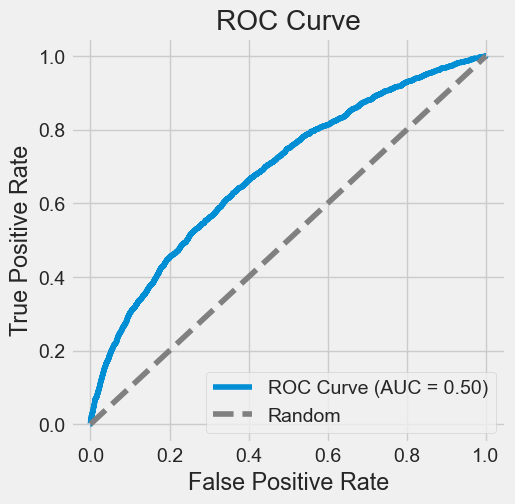

In [20]:
df_mean = df_mean.drop('id', axis=1)

X = df_mean.drop('flag', axis=1)
y = df_mean['flag']

X_train_defolt, X_test_defolt, y_train_defolt, y_test_defolt = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание экземпляра RandomForestClassifier
rf_defolt_mean = RandomForestClassifier(random_state=42, criterion='gini', max_depth=20, max_features='sqrt', min_samples_leaf=4,
                                   min_samples_split=2, n_estimators=160, verbose=0, n_jobs=-1)

rf_defolt_mean.fit(X_train_defolt, y_train_defolt)

# Получение предсказаний на тестовом наборе данных
y_pred_defolt = rf_defolt_mean.predict(X_test_defolt)
print(f'Лучшие параметры для данных при mean без балансировки')
# Вывод ROC AUC
roc_auc_defolt = roc_auc_score(y_test_defolt, y_pred_defolt)
print(f'ROC AUC: {roc_auc_defolt}')

# Вывод матрицы ошибок
conf_matrix_defolt = confusion_matrix(y_test_defolt, y_pred_defolt)
print(f'Матрица ошибок:\n{conf_matrix_defolt}')

# Вывод ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test_defolt, rf_defolt_mean.predict_proba(X_test_defolt)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_defolt:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [21]:
rus = RandomUnderSampler()

# Применение уменьшения выборки к данным
X_downscaled, y_downscaled = rus.fit_resample(X, y)
print(X_downscaled.shape)
print('________________________________')

print(y_downscaled.shape)
print('________________________________')

print(y_downscaled.value_counts())
print('________________________________')

(18618, 34)
________________________________
(18618,)
________________________________
flag
0.0    9309
1.0    9309
Name: count, dtype: int64
________________________________


Лучшие параметры для данных при mean после балансировки
ROC AUC: 0.6253854178206123
Матрица ошибок:
[[1292  596]
 [ 796 1040]]


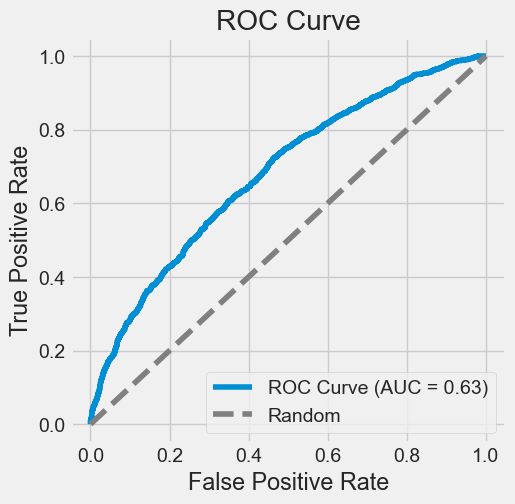

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_downscaled, y_downscaled, test_size=0.2, random_state=42)

# Создание экземпляра RandomForestClassifier
rf_mean = RandomForestClassifier(random_state=42, criterion='gini', max_depth=20, max_features='sqrt', min_samples_leaf=4,
                                   min_samples_split=2, n_estimators=160, verbose=0, n_jobs=-1)

# Обучение модели с Grid Search
rf_mean.fit(X_train, y_train)

print(f'Лучшие параметры для данных при mean после балансировки')
# Получение предсказаний на тестовом наборе данных
y_pred = rf_mean.predict(X_test)

# Вывод ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')

# Вывод матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Матрица ошибок:\n{conf_matrix}')

# Вывод ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, rf_mean.predict_proba(X_test)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [23]:
grouped_df_median = df.groupby('id').mean().reset_index()

df_median = grouped_df_median.apply(np.ceil)
df_median

,id,rn,pre_pterm,pre_fterm,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,...,enc_paym_3,enc_paym_12,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,1250000.0,2.0,15.0,10.0,16.0,4.0,2.0,0.0,2.0,8.0,...,0.0,2.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0.0
1,1250001.0,3.0,13.0,12.0,7.0,5.0,4.0,0.0,2.0,6.0,...,1.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,1.0,1.0
2,1250002.0,2.0,3.0,12.0,8.0,2.0,4.0,0.0,2.0,4.0,...,0.0,3.0,4.0,1.0,2.0,4.0,1.0,1.0,1.0,0.0
3,1250003.0,5.0,9.0,11.0,14.0,3.0,3.0,0.0,2.0,5.0,...,2.0,2.0,4.0,1.0,3.0,4.0,1.0,1.0,1.0,0.0
4,1250004.0,5.0,10.0,10.0,10.0,3.0,4.0,0.0,2.0,5.0,...,1.0,2.0,4.0,1.0,3.0,4.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,1499995.0,3.0,12.0,10.0,9.0,3.0,4.0,0.0,2.0,4.0,...,1.0,2.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0,0.0
249996,1499996.0,6.0,11.0,7.0,13.0,3.0,4.0,0.0,2.0,4.0,...,1.0,3.0,4.0,1.0,3.0,4.0,1.0,1.0,1.0,0.0
249997,1499997.0,1.0,17.0,14.0,17.0,1.0,2.0,0.0,2.0,2.0,...,0.0,3.0,4.0,1.0,2.0,4.0,1.0,0.0,0.0,0.0
249998,1499998.0,1.0,10.0,13.0,8.0,3.0,5.0,0.0,2.0,8.0,...,0.0,0.0,4.0,1.0,2.0,3.0,1.0,0.0,0.0,0.0


Лучшие параметры для данных при median без балансировки
ROC AUC: 0.5
Матрица ошибок:
[[48164     0]
 [ 1836     0]]


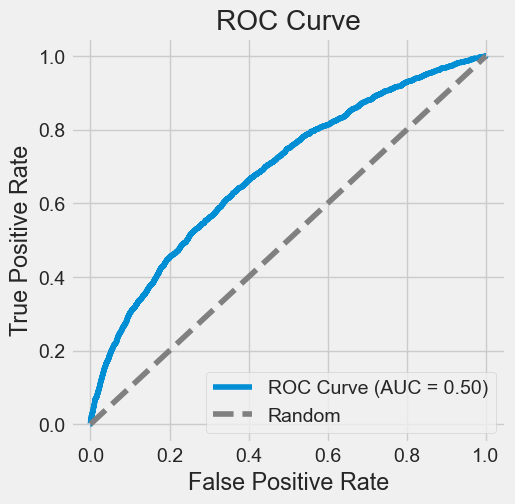

In [24]:
df_median = df_median.drop('id', axis=1)

X = df_median.drop('flag', axis=1)
y = df_median['flag']

X_train_defolt, X_test_defolt, y_train_defolt, y_test_defolt = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание экземпляра RandomForestClassifier
rf_defolt_med = RandomForestClassifier(random_state=42, criterion='gini', max_depth=20, max_features='sqrt', min_samples_leaf=4,
                                   min_samples_split=2, n_estimators=160)

rf_defolt_med.fit(X_train_defolt, y_train_defolt)

print(f'Лучшие параметры для данных при median без балансировки')
# Получение предсказаний на тестовом наборе данных
y_pred_defolt = rf_defolt_med.predict(X_test_defolt)

# Вывод ROC AUC
roc_auc_defolt = roc_auc_score(y_test_defolt, y_pred_defolt)
print(f'ROC AUC: {roc_auc_defolt}')

# Вывод матрицы ошибок
conf_matrix_defolt = confusion_matrix(y_test_defolt, y_pred_defolt)
print(f'Матрица ошибок:\n{conf_matrix_defolt}')

# Вывод ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test_defolt, rf_defolt_med.predict_proba(X_test_defolt)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_defolt:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Лучшие параметры для данных при mean после балансировки
ROC AUC: 0.6253854178206123
Матрица ошибок:
[[1292  596]
 [ 796 1040]]


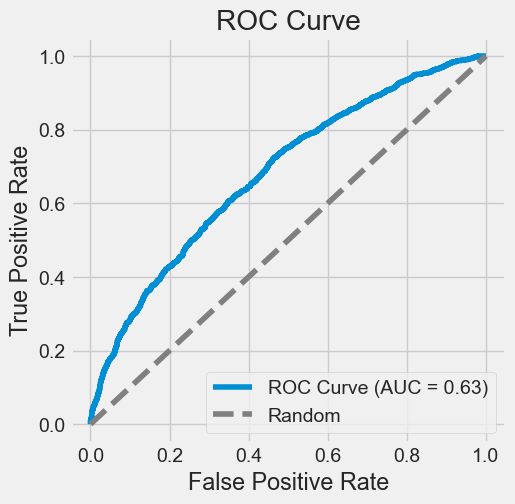

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_downscaled, y_downscaled, test_size=0.2, random_state=42)

# Создание экземпляра RandomForestClassifier
rf_med = RandomForestClassifier(random_state=42, criterion='gini', max_depth=20, max_features='sqrt', min_samples_leaf=4,
                            min_samples_split=2, n_estimators=160)

rf_med.fit(X_train, y_train)

print(f'Лучшие параметры для данных при mean после балансировки')
# Получение предсказаний на тестовом наборе данных
y_pred_med = rf_med.predict(X_test)

# Вывод ROC AUC
roc_auc_med = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc_med}')

# Вывод матрицы ошибок
conf_matrix_med = confusion_matrix(y_test, y_pred)
print(f'Матрица ошибок:\n{conf_matrix_med}')

# Вывод ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, rf_med.predict_proba(X_test)[:, 1])
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

В целом видим, что метрика не изменилась, одинаково 62%, но очевидно увеличилась скорость построения модели. Стоит посмотреть на нее при использовании всех данных. 
Реализуем сборку всех данных в файле Compile_dataset_base и перейдем к экспериментам в файл Analysis_main. Там посмотрим на поведение данных и моделей на сборке из всех паркет-файлов. 